# Miniproject 3: 7-Bit DAC

In [ ]:
import matplotlib.pyplot as plt
import numpy
import math
import sys

from IPython.display import SVG, Image, Markdown, display
from pathlib import Path

from util.simulation import (
    get_project_root,
    get_netlist,
    run_simulation,
    parse_data,
    export_schematic,
    light_sea_green,
    bittersweet,
    black,
)
from util.dac import (
    calculate_inl,
    calculate_dnl,
    adjust_m2m_ladder_tb_netlist,
    adjust_bias_gen_tb_netlist,
    run_monte_carlo
)

# setup paths
project_root = get_project_root()
analog_schematic_directory = project_root.joinpath("lib/analog/schematic")
analog_symbol_directory = project_root.joinpath("lib/analog/symbol")
mp_root = project_root.joinpath("dac")
sim_directory = mp_root.joinpath("build")
layout_directory = mp_root.joinpath("layout")
media_directory = mp_root.joinpath("report/media")
%load_ext autoreload

## DAC Schematic Capture

### M-2M Ladder

The first component of a R-2R MOSFET-only DAC is M-2M ladder network to divide an input current and sum currents based on the input digital code. I created a ladder based on the work of Hammerschmied and Haung [1], shown below. For now, the transistor widths and lengths are kept as variables.

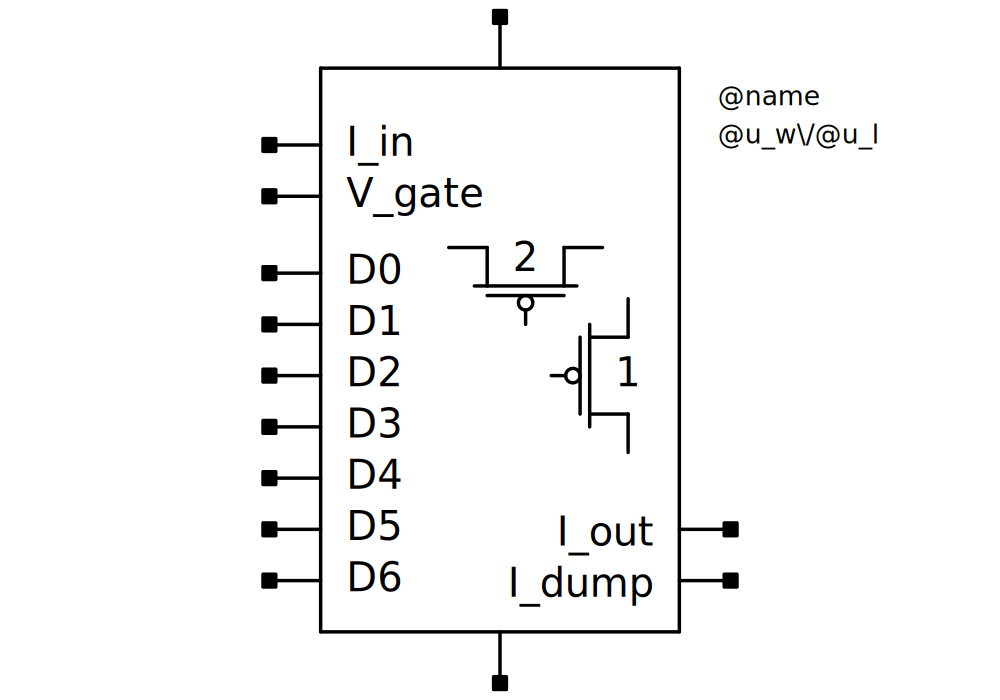

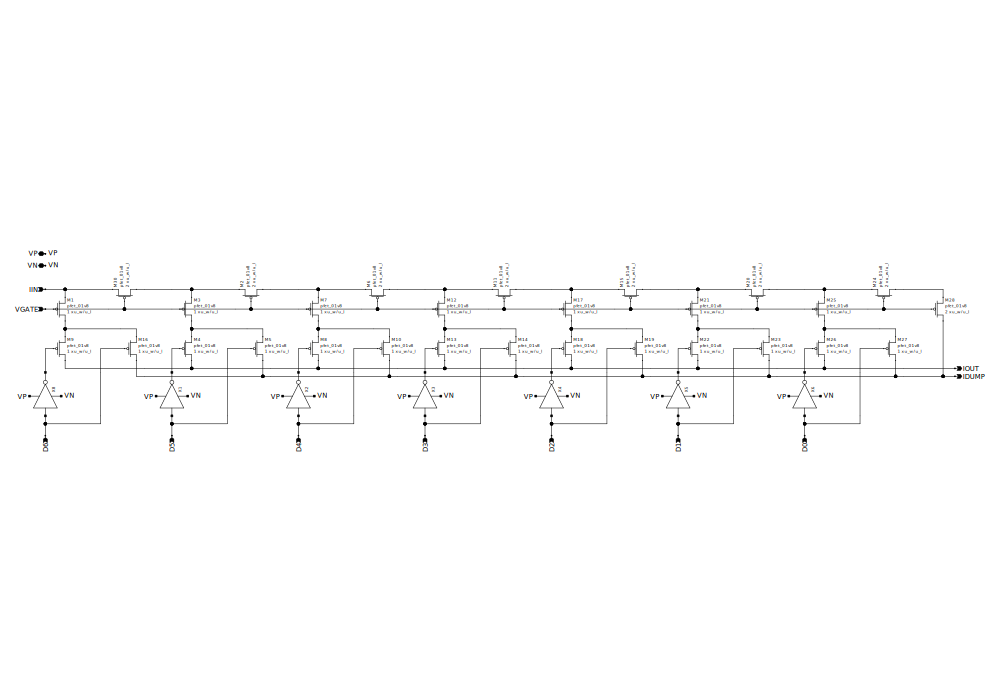

In [ ]:
%autoreload 2
m2m_ladder_schematic = analog_schematic_directory.joinpath("m2m_ladder_pmos.sch")
m2m_ladder_symbol = analog_symbol_directory.joinpath("m2m_ladder_pmos.sym")
export_schematic(schematic=m2m_ladder_schematic, output=media_directory.joinpath("m2m_ladder_pmos_sch.svg"))
export_schematic(schematic=m2m_ladder_symbol, output=media_directory.joinpath("m2m_ladder_pmos_sym.svg"))
display(SVG(media_directory.joinpath("m2m_ladder_pmos_sym.svg")))
display(SVG(media_directory.joinpath("m2m_ladder_pmos_sch.svg")))

### M-2M Isat VTC

With the M-2M ladder complete, I swept the gate voltage with the ladder saturated to find the saturation current as a function of the gate voltage. The M-2M ladder can be simplified down to single transistor of width a multiple of 2 of the unit transistor, as shown below. Choosing a bias current in moderate inversion may be advantageous for power and bandwidth, though for completeness, the gate voltage can be swept across all levels of inversion.

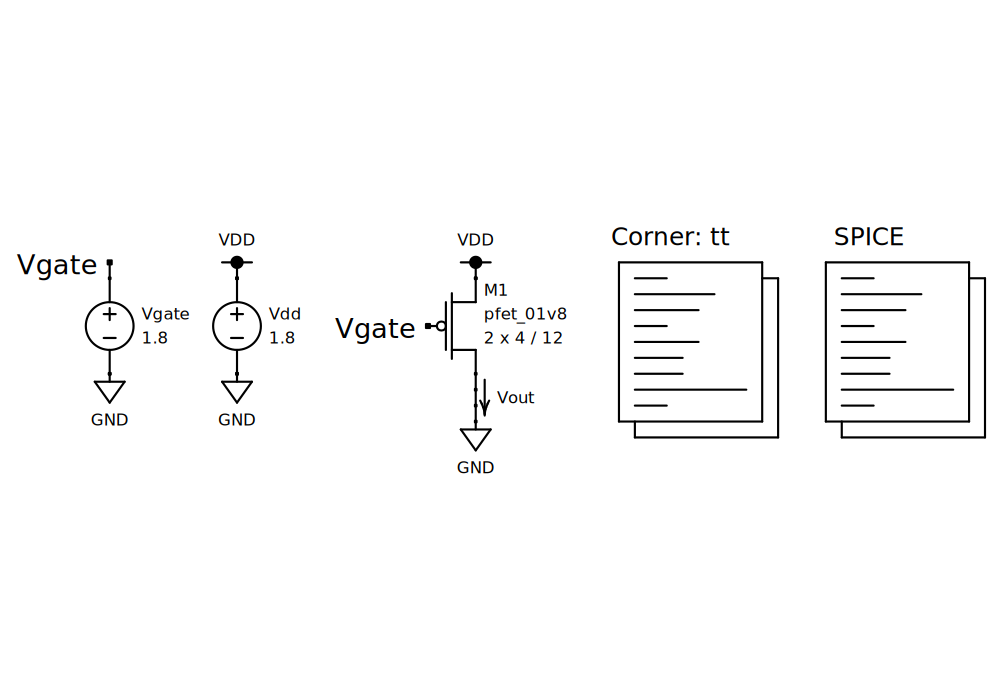

In [21]:
%autoreload 2
_2m_isat_isat_tb_schematic = mp_root.joinpath("schematic/2m_isat_tb.sch")
export_schematic(schematic=_2m_isat_isat_tb_schematic, output=media_directory.joinpath("2m_isat_tb.svg"))
display(SVG(media_directory.joinpath("2m_isat_tb.svg")))

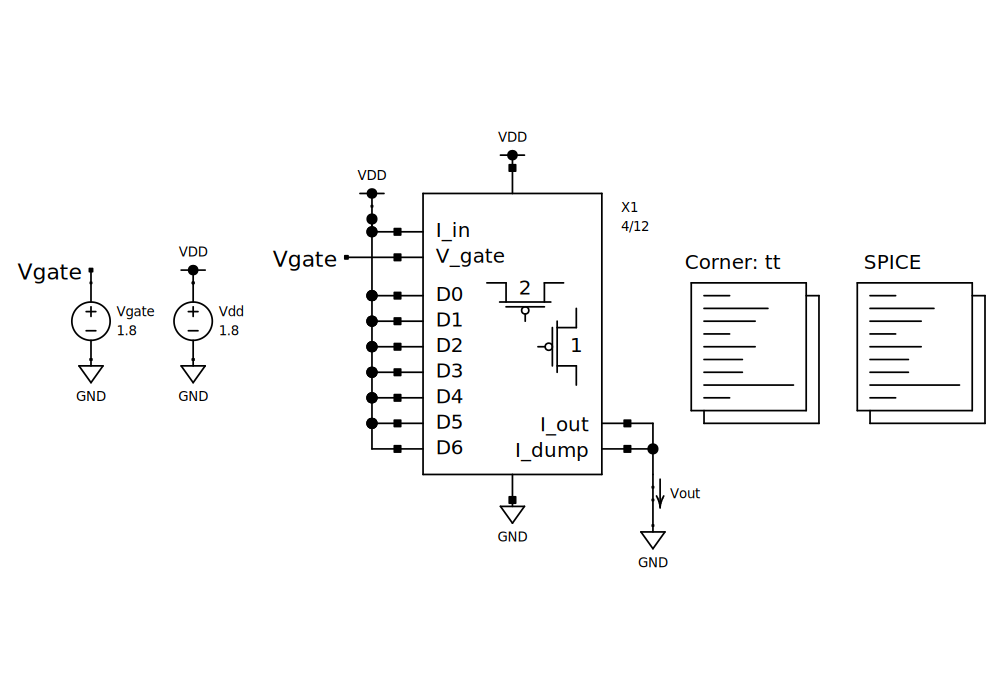

In [ ]:
%autoreload 2
m2m_ladder_isat_tb_schematic = mp_root.joinpath("schematic/m2m_ladder_isat_tb.sch")
export_schematic(schematic=m2m_ladder_isat_tb_schematic, output=media_directory.joinpath("m2m_ladder_isat.svg"))
display(SVG(media_directory.joinpath("m2m_ladder_isat.svg")))

In [ ]:
%autoreload 2
# run 2m and m2m ladder saturation simulations
_2m_isat_sim_directory = sim_directory.joinpath("2m_isat")
_2m_isat_netlist = get_netlist(
    schematic=_2m_isat_isat_tb_schematic, output=_2m_isat_sim_directory
)
_2m_isat_data_file = run_simulation(
    netlist=_2m_isat_netlist, output=_2m_isat_sim_directory
)

m2m_ladder_isat_sim_directory = sim_directory.joinpath("m2m_ladder_isat")
m2m_ladder_isat_netlist = get_netlist(
    schematic=m2m_ladder_isat_tb_schematic, output=m2m_ladder_isat_sim_directory
)
m2m_ladder_isat_data_file = run_simulation(
    netlist=m2m_ladder_isat_netlist, output=m2m_ladder_isat_sim_directory
)

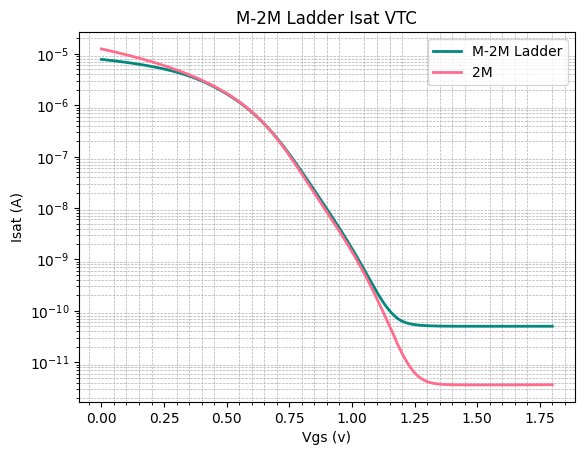

In [ ]:
%autoreload 2
m2m_ladder_isat_data, _ = parse_data(m2m_ladder_isat_data_file)
_2m_isat_data, _ = parse_data(_2m_isat_data_file)

plt.figure()
plt.title("M-2M Ladder Isat VTC")
plt.xlabel("Vgs (v)")
plt.ylabel("Isat (A)")
plt.grid(which="minor", linestyle="--", linewidth=0.5)
plt.minorticks_on()
plt.semilogy(
    m2m_ladder_isat_data["v-sweep"],
    m2m_ladder_isat_data["i(Vout)"],
    color=light_sea_green,
    linewidth=2,
)
plt.semilogy(
    _2m_isat_data["v-sweep"],
    _2m_isat_data["i(Vout)"],
    color=bittersweet,
    linewidth=2,
)
plt.legend(["M-2M Ladder", "2M"])

### Ladder Current Selection
With the saturation voltage in mind, I then swept the gate voltage of the M-2M ladder and calculated the INL and DNL.

In [ ]:
%autoreload 2

### M-2M Ladder Optimization
inl_ranges = []
dnl_ranges = []
bias_currents = []
gate_voltages = []

index = 0
min_inl_range = sys.maxsize
min_dnl_range = sys.maxsize
min_inl_sim: Path
min_dnl_sim: Path
min_inl_index: int
min_dnl_index: int

for input_current, gate_voltage in zip(m2m_ladder_isat_data["i(Vout)"], m2m_ladder_isat_data["v-sweep"]):
  m2m_ladder_sim_directory = sim_directory.joinpath("m2m_ladder")
  m2m_ladder_tb_schematic = mp_root.joinpath("schematic/m2m_ladder_tb.sch")

  m2m_ladder_netlist = get_netlist(
      schematic=m2m_ladder_tb_schematic, output=m2m_ladder_sim_directory
  )

  adjust_m2m_ladder_tb_netlist(
      file=m2m_ladder_netlist, i_in=input_current, v_gate=gate_voltage
  )

  m2m_ladder_data = run_simulation(
      netlist=m2m_ladder_netlist, output=m2m_ladder_sim_directory, filename=f"m2m_ladder_{gate_voltage}.txt"
  )

  min_inl, max_inl, _ = calculate_inl(file=m2m_ladder_data, input_current=input_current, suppress_plot=True)
  min_dnl, max_dnl, _ = calculate_dnl(file=m2m_ladder_data, input_current=input_current, suppress_plot=True)

  inl_ranges.append(max_inl - min_inl)
  dnl_ranges.append(max_dnl - min_dnl)
  bias_currents.append(input_current)
  gate_voltages.append(gate_voltage)

  if max_inl - min_inl < min_inl_range:
    min_inl_range = max_inl - min_inl
    min_inl_sim = m2m_ladder_data
    min_inl_index = index

  if max_dnl - min_dnl < min_dnl_range:
    min_dnl_range = max_dnl - min_dnl
    min_dnl_sim = m2m_ladder_data
    min_dnl_index = index

  index+=1



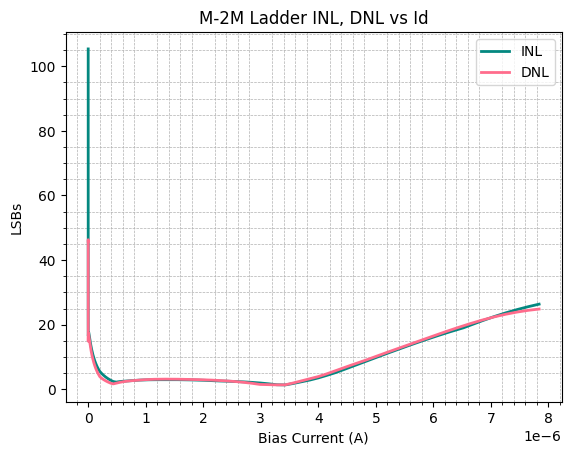

In [34]:
plt.figure()
plt.title("M-2M Ladder INL, DNL vs Id")
plt.xlabel("Bias Current (A)")
plt.ylabel("LSBs")
plt.grid(which="minor", linestyle="--", linewidth=0.5)
plt.minorticks_on()
plt.plot(
    bias_currents,
    inl_ranges,
    color=light_sea_green,
    linewidth=2,
)
plt.plot(
    bias_currents,
    dnl_ranges,
    color=bittersweet,
    linewidth=2,
)
plt.legend(["INL", "DNL"])

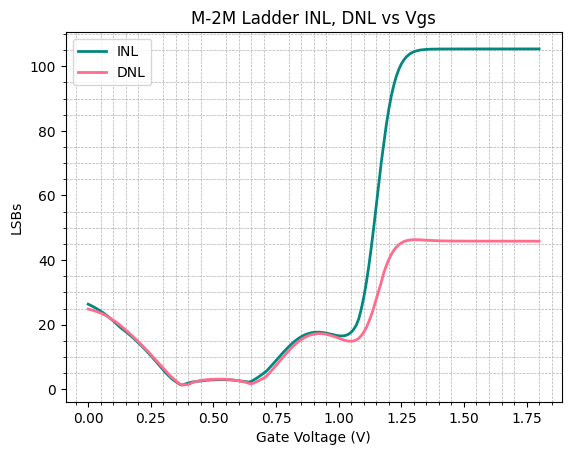

In [39]:
plt.figure()
plt.title("M-2M Ladder INL, DNL vs Vgs")
plt.xlabel("Gate Voltage (V)")
plt.ylabel("LSBs")
plt.grid(which="minor", linestyle="--", linewidth=0.5)
plt.minorticks_on()
plt.plot(
    gate_voltages,
    inl_ranges,
    color=light_sea_green,
    linewidth=2,
)
plt.plot(
    gate_voltages,
    dnl_ranges,
    color=bittersweet,
    linewidth=2,
)
plt.legend(["INL", "DNL"])

(-0.18259912586774873, 1.2069193875795405)

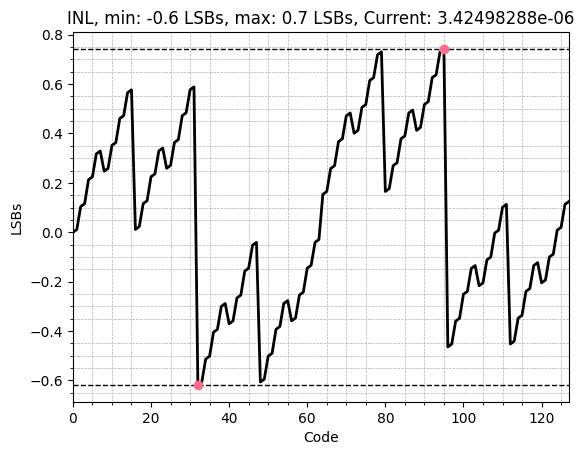

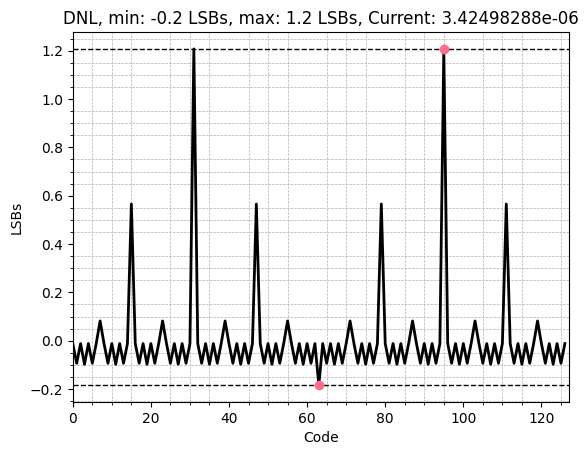

In [36]:
calculate_inl(file=min_inl_sim, input_current=bias_currents[min_inl_index])
calculate_dnl(file=min_inl_sim, input_current=bias_currents[min_inl_index]) # purposefully use inl

Based on the results of the brute force simulation above, a gate voltage of $V_{gs} = 0.37V$ and ladder current of $I_d = 3.4uA$ produces the lowest INL. In the "M-2M Ladder INL, DNL vs Vgs" plot above, there are two local minima - one at approximately $V_{gs} = 0.37V$ and the other at $V_{gs} = 0.7V$. Although $V_{gs} = 0.7V$ would result in lower power consumption, INL and DNL remain flatter around $V_{gs} = 0.37V$ with variations in bias current. For that reason, $V_{gs} = 0.37V$ was selected as the target bias voltage for the ladder such that process variations have a lower impact.

In [77]:
target_vbp = 0.37
target_ladder_current = 3.425e-6
target_bias_current = target_ladder_current / 2 # divide by 2 due to ladder strength ratio of 2

#### Unit Transistor Dimensions
Because of short channel modulation, the length of the transistor should ideally be greater than 4um [2]. I originally choose a transistor size of 1/3, but increased to 4/12 to reduce short channel effects. With the selected target ladder current above, the ladder and bia gen are operating in moderate inversion. However, using a higher strength ratio and operating in weak inversion would increase output impedance and reduce short channel effect further. Unfortunately, I did not have time to investigate high strength ratios in weak inversion.

### Supply Independent Bias Generation
Supply independent bias generation can be achieved using the bia generator show below.

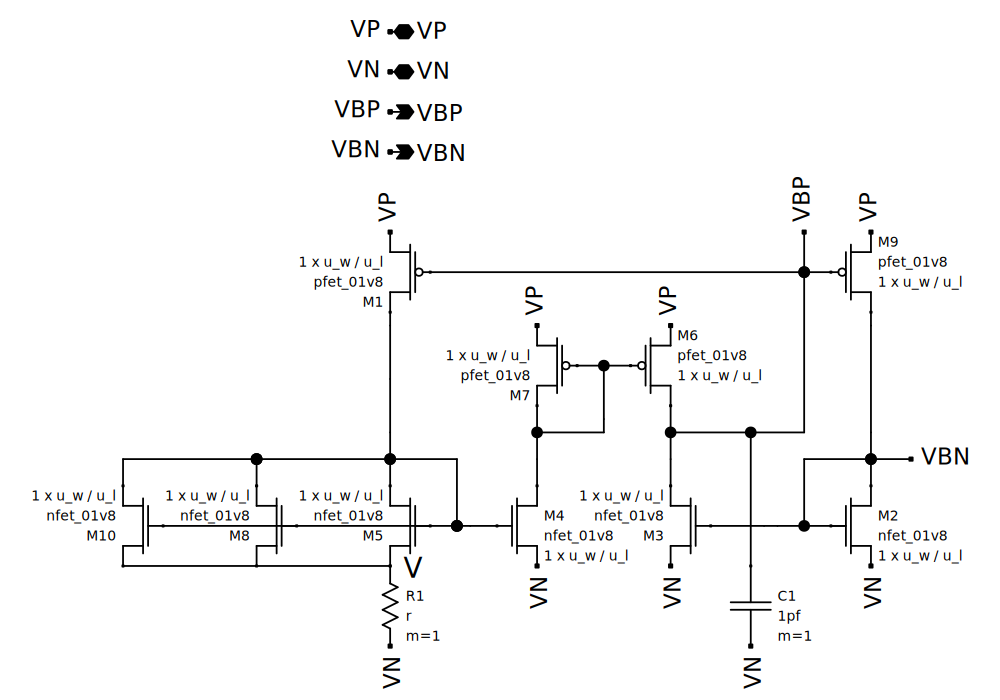

In [48]:
%autoreload 2
bias_gen_schematic = analog_schematic_directory.joinpath("bias_gen.sch")
export_schematic(schematic=bias_gen_schematic, output=media_directory.joinpath("bias_gen.svg"))
display(SVG(media_directory.joinpath("bias_gen.svg")))

Selection of the degeneration resistor R and strength of the bias gen transistor can be calculated using the EKV model.

All transistors in the bias gen circuit operate in saturation, so starting with $I_{sat}$ of M2 and solving for $V_{ds2}$:

$$I_b = I_s \log{1 + e^{\frac{\kappa (V_{ds2} - V_{T0})}{2U_{t}}}}$$

$$e^{\sqrt{\frac{I_b}{I_s}}} - 1 = e^{\frac{\kappa (V_{ds2} - V_{T0})}{2U_{t}}}$$

$$2U_t \log{e^{\sqrt{\frac{I_b}{I_s}}}-1} = \kappa (V_{ds2} - V_{T0})$$

$$V_{ds2} = \frac{2U_t}{\kappa} \log{e^{\sqrt{\frac{I_b}{I_s}}}-1} + V_{T0}$$

If V is the drain of the M5, M8, and M10, the current is:

$$I_b = M I_s \log{1 + e^{\frac{\kappa (V_{ds1} + V - V_{T0}) - V}{2U_{t}}}}$$

Because of the M1, M9 current mirror and because of the connection between the drain and gate of M2, M5, M8, and M10:

$$V_{ds1} + V = V{ds2}$$

Substituting $V_{ds2}$ for $V_{ds1} + V$:

$$I_b = M I_s \log{1 + e^{\frac{\kappa \left(\frac{2U_t}{\kappa} \log{e^{\sqrt{\frac{I_b}{I_s}}}-1} + V_{T0} - V_{T0}\right) - V}{2U_{t}}}}$$

$$I_b = M I_s \log{1 + e^{\frac{\kappa \left(\frac{2U_t}{\kappa} \log{e^{\sqrt{\frac{I_b}{I_s}}}-1} \right) - V}{2U_{t}}}}$$

Solving for R:

$$R = \frac{2 U_t \log\left({e^{\frac{I_b}{I_s}} - 1}\right) - 2 U_t \log\left({e^{\frac{I_b}{I_s M}} - 1}\right)}{I_b}$$


In [49]:
# bias gen degeneration resistor calculation
Ut = 25.86e-3 # volts, thermal voltage
Ib = target_bias_current
M = 3 # degenerated mosfet strength
Is = 700e-9 # amps, specific current typ.
Vt0 = 700e-3 # volts, threshold voltage typ.
k = 0.6 # unitless, typ.

R = (2 * Ut * math.log(math.e**(math.sqrt((3*Ib)/Is)) - 1) - 2 * Ut * math.log(math.e**(math.sqrt((3*Ib)/(M*Is)))-1)) / Ib
print("Degeneration resistor", R)

Degeneration resistor 39590.88741515288


Due to second order effects, calculation of the degeneration resistor is not accurate enough to use on its own. Sweeping around the calculated resistor allows for the selection of a resistor based on the output bias voltage. The below testbench and simulation finds the best degeneration resistor.

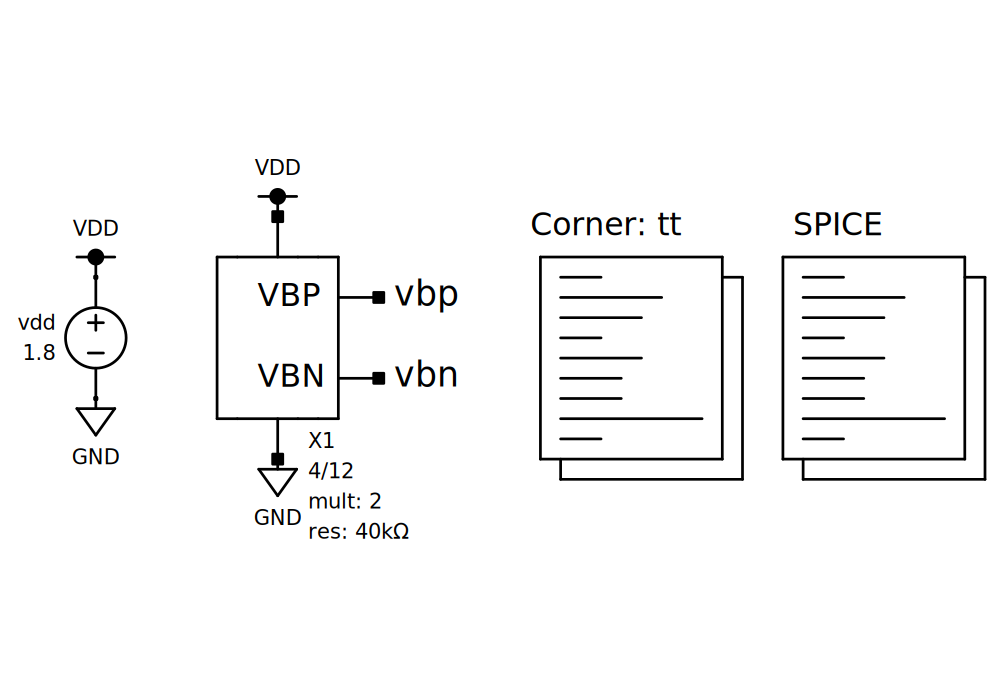

In [73]:
%autoreload 2
bias_gen_tb_schematic = mp_root.joinpath("schematic/bias_gen_tb.sch")
export_schematic(schematic=bias_gen_tb_schematic, output=media_directory.joinpath("bias_gen_tb.svg"))
display(SVG(media_directory.joinpath("bias_gen_tb.svg")))

In [78]:
%autoreload 2

candidate_resistors = [35e3 + 1e3 * index for index in range(0,10)]
nmos_bias_voltages = []
pmos_bias_voltages = []

bias_gen_sim_directory = sim_directory.joinpath("bias_gen")
bias_gen_netlist = get_netlist(
    schematic=bias_gen_tb_schematic, output=bias_gen_sim_directory
)

for resistor in candidate_resistors:
    adjust_bias_gen_tb_netlist(file=bias_gen_netlist, u_w=4, u_l=12, mult=2, res=resistor)

    bias_gen_data_file = run_simulation(
        netlist=bias_gen_netlist, output=bias_gen_sim_directory
    )
    bias_gen_data, _ = parse_data(bias_gen_data_file)
    nmos_bias_voltages.append(bias_gen_data["v(vbn)"][-1])
    pmos_bias_voltages.append(bias_gen_data["v(vbp)"][-1])

Preferred degeneration resistor: 43000.0, voltage: 0.373003964


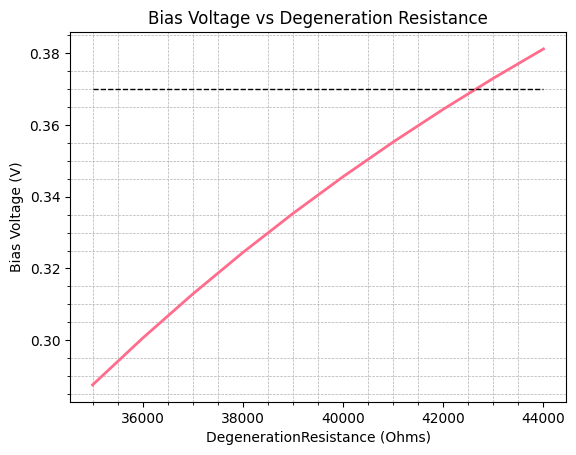

In [79]:
ladder_pmos_bias_index = numpy.argmin(numpy.abs(numpy.array(pmos_bias_voltages)-target_vbp))

print(
    f"Preferred degeneration resistor: {candidate_resistors[ladder_pmos_bias_index]}, voltage: {pmos_bias_voltages[ladder_pmos_bias_index]}"
)
plt.figure()
plt.title("Bias Voltage vs Degeneration Resistance")
plt.xlabel("DegenerationResistance (Ohms)")
plt.ylabel("Bias Voltage (V)")
plt.grid(which="minor", linestyle="--", linewidth=0.5)
plt.minorticks_on()
plt.plot(
    candidate_resistors,
    pmos_bias_voltages,
    color=bittersweet,
    linewidth=2,
)
plt.hlines(target_vbp, candidate_resistors[0], candidate_resistors[-1], linestyle="--", linewidth=1, color=black)

A degeneration resistor of around $42.6k\Omega$ created a bias voltage of approximately 0.37V.

### Biased M-2M Ladder

With a supply independent bias generator and an M-2M ladder, I connected both, then simulated and calculated the INL and DNL. As long as the current source transistor and ladder remain in saturation, the INL and DNL should be comparable to the ladder biased by an ideal current source. Below is the test bench with the bias gen and ladder.

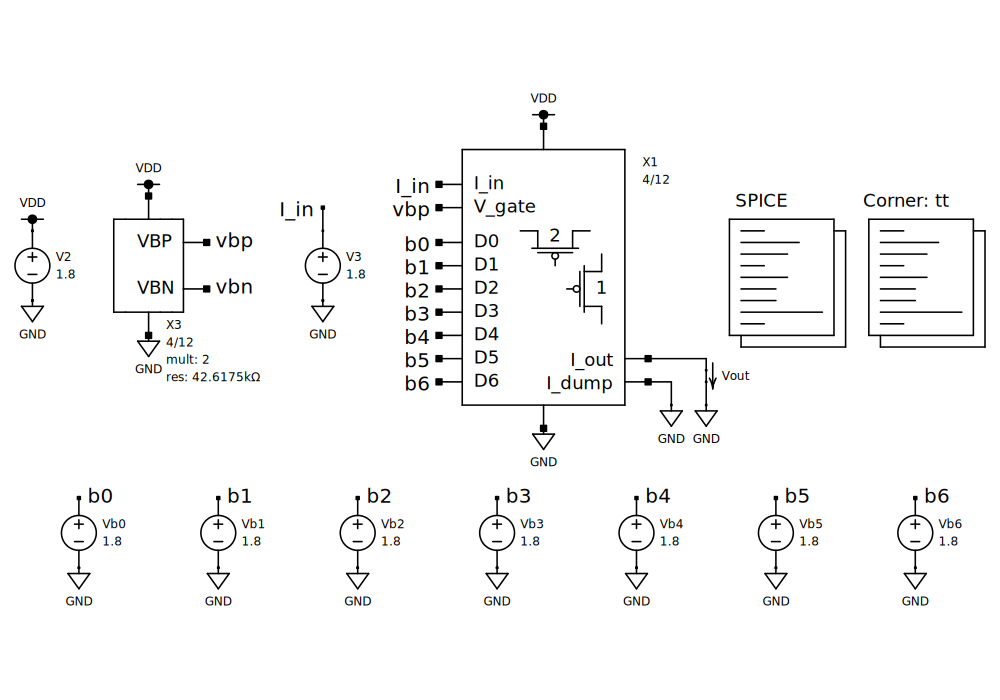

In [105]:
%autoreload 2
m2m_ladder_biased_tb_schematic = mp_root.joinpath("schematic/m2m_ladder_biased_tb.sch")
export_schematic(schematic=m2m_ladder_biased_tb_schematic, output=media_directory.joinpath("m2m_ladder_biased_tb.svg"))
display(SVG(media_directory.joinpath("m2m_ladder_biased_tb.svg")))

(-0.19743813138686173, 1.2075463381021927)

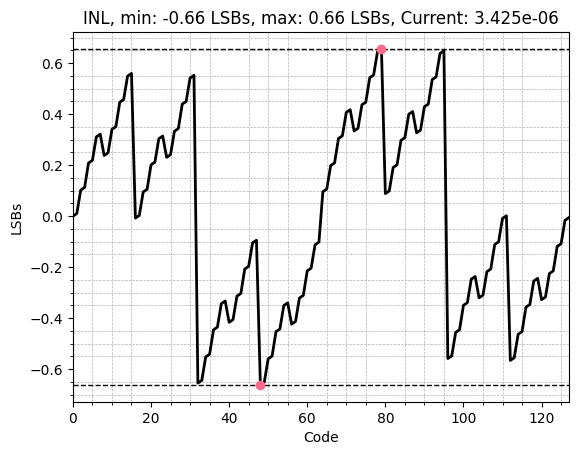

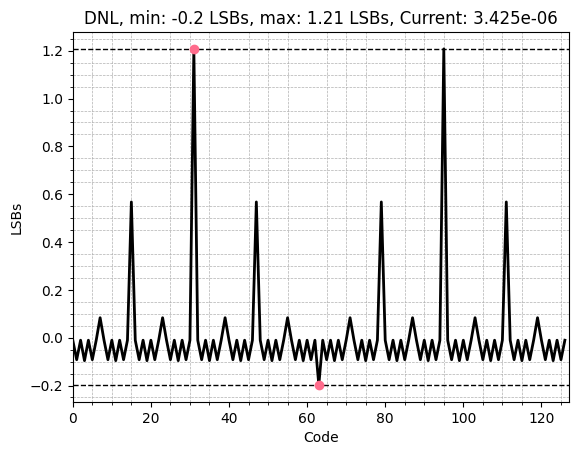

In [75]:
m2m_ladder_biased_sim_directory = sim_directory.joinpath("m2m_ladder_biased")
m2m_ladder_biased_netlist = get_netlist(
    schematic=m2m_ladder_biased_tb_schematic, output=m2m_ladder_biased_sim_directory
)

m2m_ladder_biased_data = run_simulation(
    netlist=m2m_ladder_biased_netlist, output=m2m_ladder_biased_sim_directory
)
calculate_inl(file=m2m_ladder_biased_data, input_current=target_ladder_current)
calculate_dnl(file=m2m_ladder_biased_data, input_current=target_ladder_current)


### Current Mirror

Mirroring the current is important to increase the output impedance. I selected the low-voltage stacked mirror, detailed in [3]. 

Below is the current mirror schematic and testbench, then a test sweep of the output voltage and current.

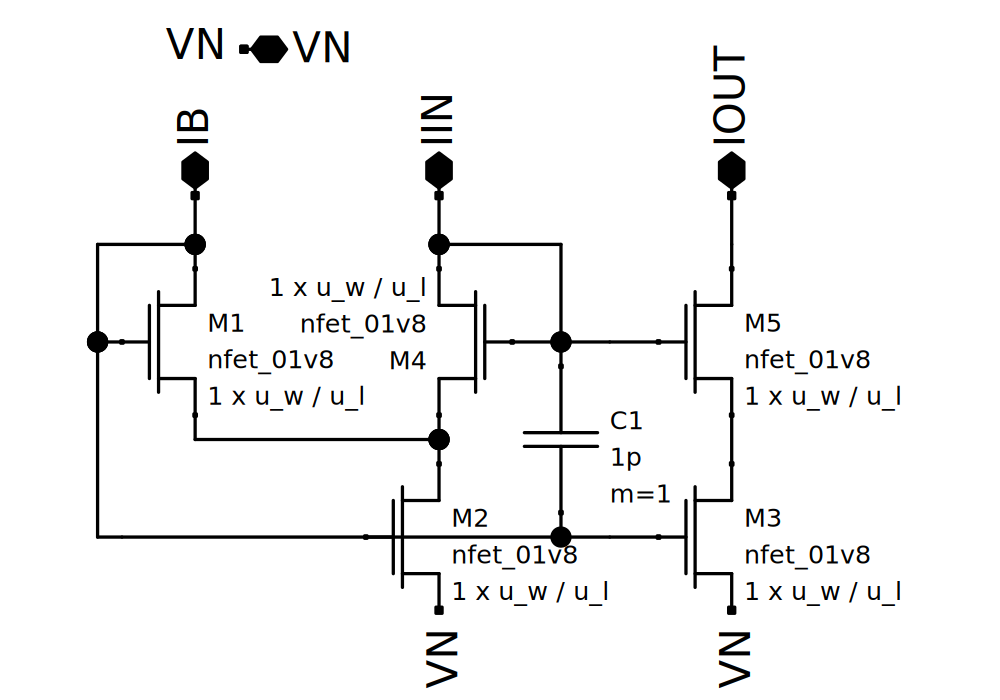

In [78]:
%autoreload 2
lvs_mirror_schematic = analog_schematic_directory.joinpath("lvs_mirror.sch")
export_schematic(schematic=lvs_mirror_schematic, output=media_directory.joinpath("lvs_mirror.svg"))
display(SVG(media_directory.joinpath("lvs_mirror.svg")))

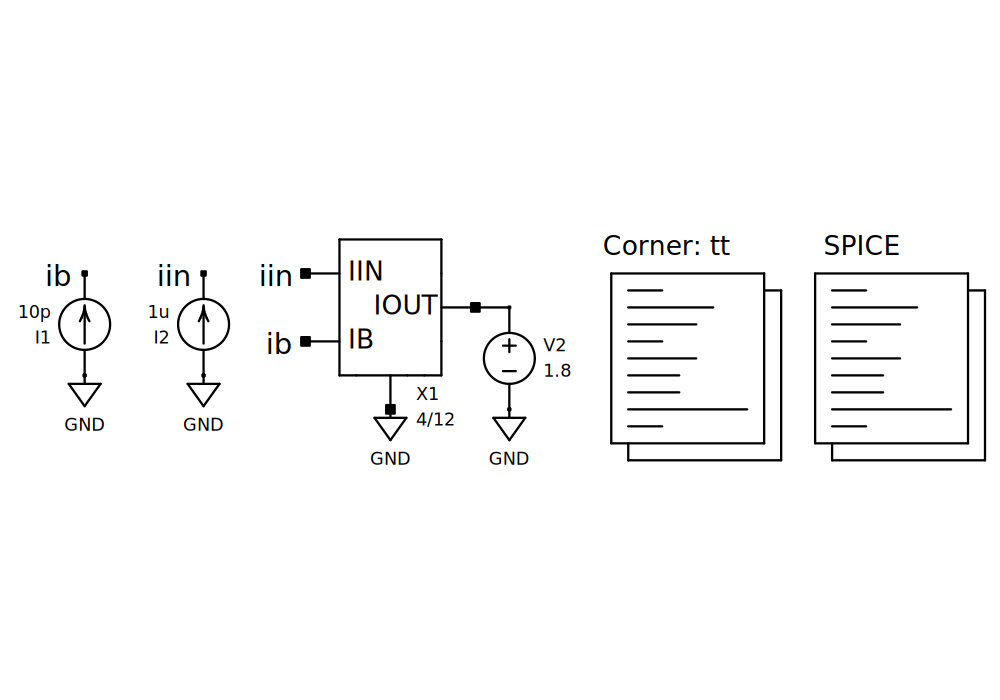

In [101]:
%autoreload 2
lvs_mirror_tb_schematic = mp_root.joinpath("schematic/lvs_mirror_tb.sch")
export_schematic(schematic=lvs_mirror_tb_schematic, output=media_directory.joinpath("lvs_mirror_tb.svg"))
display(SVG(media_directory.joinpath("lvs_mirror_tb.svg")))

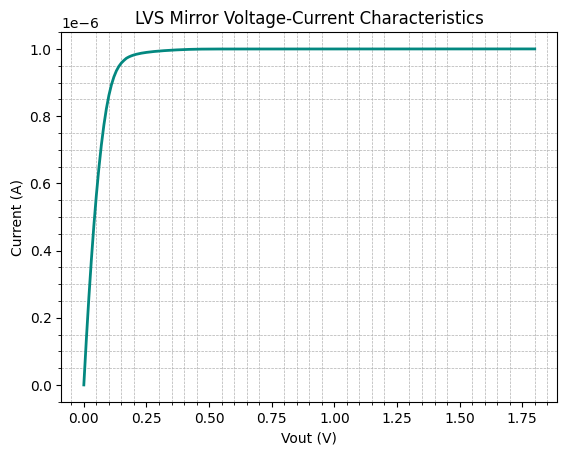

In [100]:
lvs_mirror_sim_directory = sim_directory.joinpath("lvs_mirror")

lvs_mirror_netlist = get_netlist(
    schematic=lvs_mirror_tb_schematic, output=lvs_mirror_sim_directory
)
lvs_mirror_data = run_simulation(
    netlist=lvs_mirror_netlist, output=lvs_mirror_sim_directory
)

data, _ = parse_data(lvs_mirror_data)

plt.figure()
plt.title("LVS Mirror Voltage-Current Characteristics")
plt.xlabel("Vout (V)")
plt.ylabel("Current (A)")
plt.grid(which="minor", linestyle="--", linewidth=0.5)
plt.minorticks_on()
plt.plot(
    data["v-sweep"],
    [-1 * current for current in data["i(V2)"]],
    color=light_sea_green,
    linewidth=2,
)

### Mirrored DAC
The low-voltage stacked mirror connected to the output of the M-2M ladder. The INL and DNL can once again be checked with the addition of the current mirror.

Importantly, for this test bench the current mirror is biased from an ideal current source. A current divider will be added in a later section.

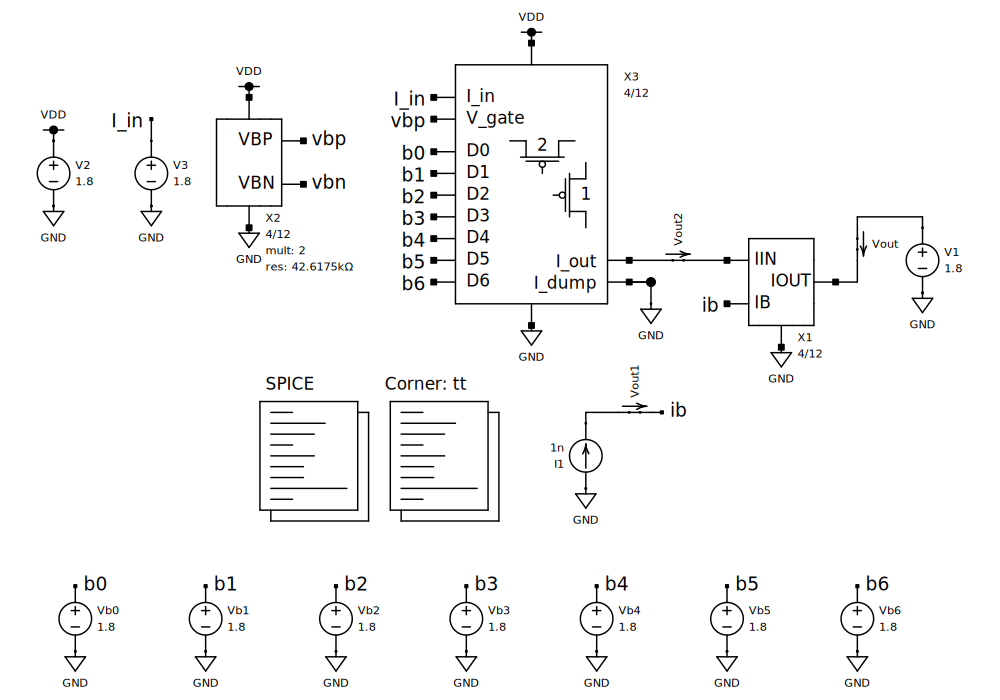

In [118]:
%autoreload 2
m2m_ladder_pseudo_biased_mirrored_tb_schematic = mp_root.joinpath("schematic/m2m_ladder_pseudo_biased_mirrored_tb.sch")
export_schematic(schematic=m2m_ladder_pseudo_biased_mirrored_tb_schematic, output=media_directory.joinpath("m2m_ladder_pseudo_biased_mirrored_tb.svg"))
display(SVG(media_directory.joinpath("m2m_ladder_pseudo_biased_mirrored_tb.svg")))

(-0.23826321751824886, 1.2058228040875898)

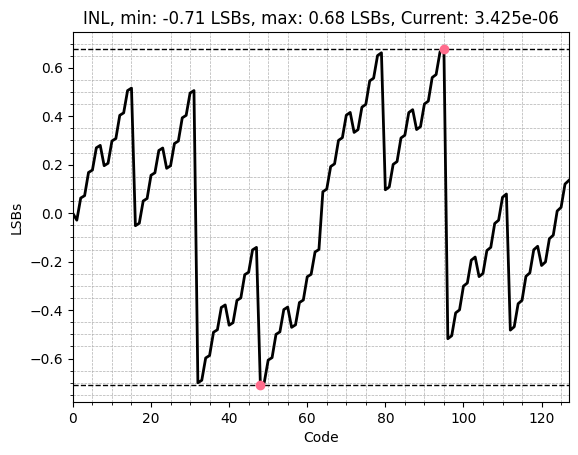

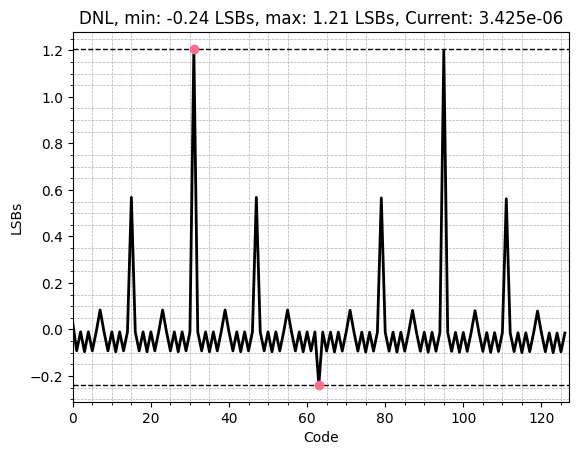

In [119]:
m2m_ladder_pseudo_biased_mirrored_sim_directory = sim_directory.joinpath("m2m_ladder_pseudo_biased_mirrored")

m2m_ladder_psuedo_biased_mirrored_netlist = get_netlist(
    schematic=m2m_ladder_pseudo_biased_mirrored_tb_schematic, output=m2m_ladder_pseudo_biased_mirrored_sim_directory
)

m2m_ladder_psuedo_biased_mirrored_data = run_simulation(
    netlist=m2m_ladder_psuedo_biased_mirrored_netlist, output=m2m_ladder_pseudo_biased_mirrored_sim_directory
)

calculate_inl(file=m2m_ladder_psuedo_biased_mirrored_data, input_current=target_ladder_current)
calculate_dnl(file=m2m_ladder_psuedo_biased_mirrored_data, input_current=target_ladder_current)

### Current Divider
The low voltage stacked mirror requires a bias current much smaller than the input current - on the order of nAs is sufficient as shown in the mirrored DAC simulation above. The bias current can be copied from the bias generator, then divided with a M-2M ladder in much the same way as the M-2M ladder.

Below is the current divider and its testbench, followed by a simulation and its output current.

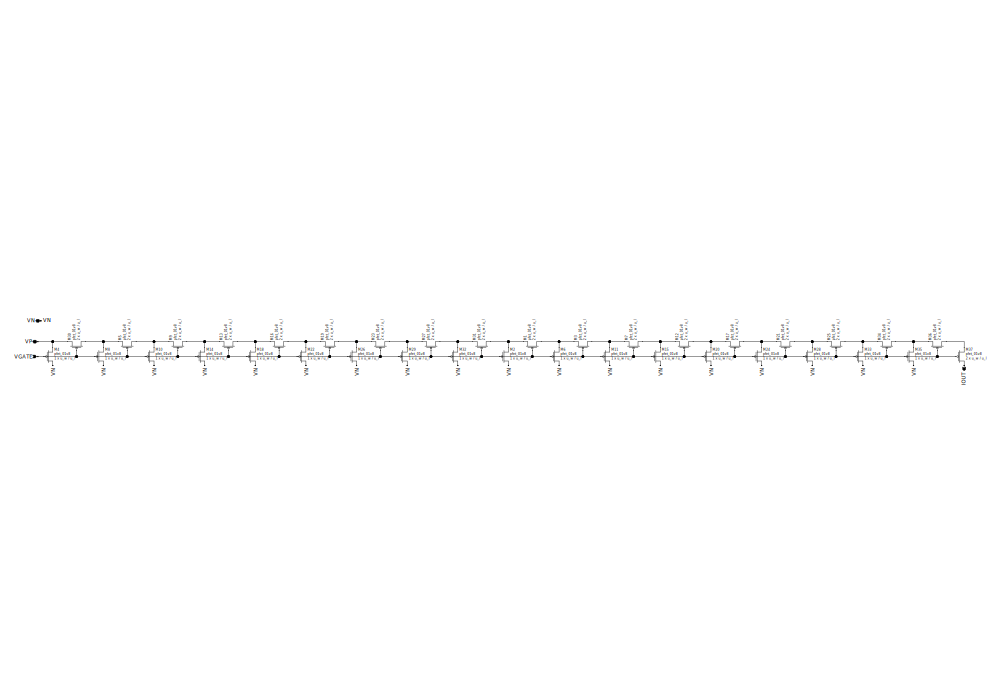

In [123]:
%autoreload 2
current_divider_schematic = analog_schematic_directory.joinpath("current_divider.sch")
export_schematic(schematic=current_divider_schematic, output=media_directory.joinpath("current_divider.svg"))
display(SVG(media_directory.joinpath("current_divider.svg")))

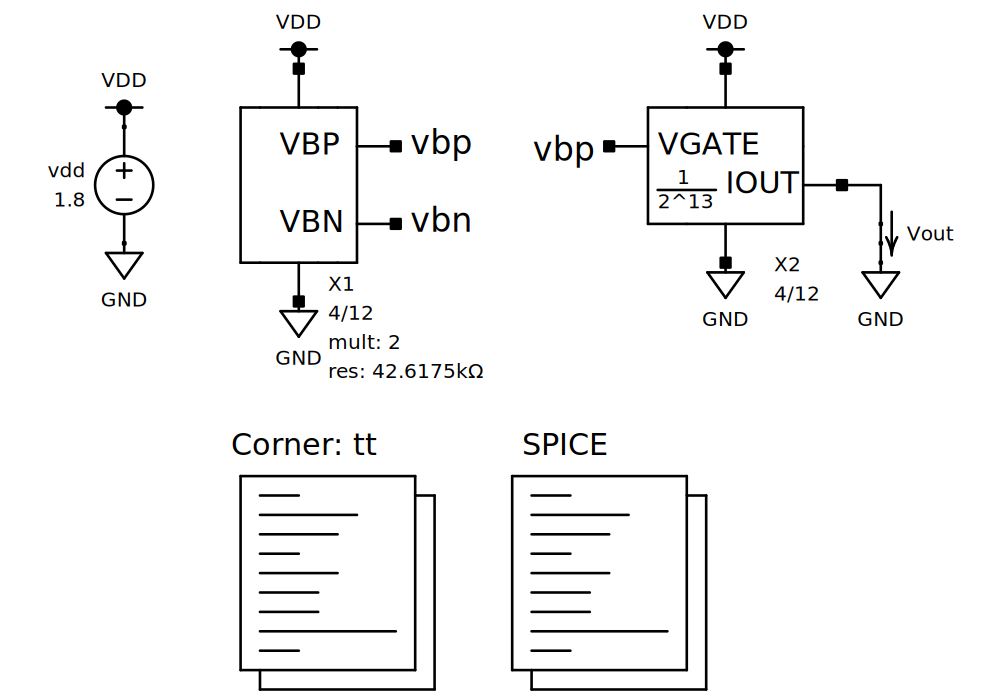

In [143]:
%autoreload 2
current_divider_tb_schematic = mp_root.joinpath("schematic/current_divider_tb.sch")
export_schematic(schematic=current_divider_tb_schematic, output=media_directory.joinpath("current_divider_tb.svg"))
display(SVG(media_directory.joinpath("current_divider_tb.svg")))

In [136]:
current_divider_sim_directory = sim_directory.joinpath("current_divider")
current_divider_tb_schematic = mp_root.joinpath("schematic/current_divider_tb.sch")

current_divider_netlist = get_netlist(
    schematic=current_divider_tb_schematic, output=current_divider_sim_directory
)

current_divider_data = run_simulation(
    netlist=current_divider_netlist, output=current_divider_sim_directory
)


data, _ = parse_data(current_divider_data)

print("Current divider output: ", data["i(Vout)"])

Current divider output:  [9.6838384e-10]


### Complete DAC
With the current divider complete, it can be added to the DAC and simulated. 

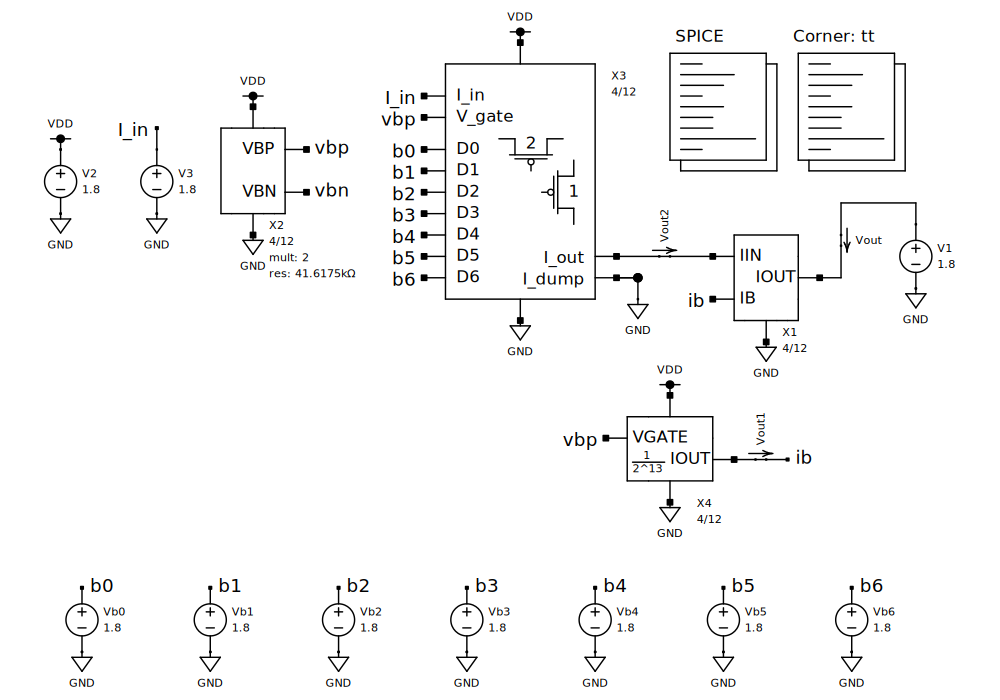

In [138]:
%autoreload 2
m2m_ladder_biased_mirrored_tb_schematic = mp_root.joinpath("schematic/m2m_ladder_biased_mirrored_tb.sch")
export_schematic(schematic=m2m_ladder_biased_mirrored_tb_schematic, output=media_directory.joinpath("m2m_ladder_biased_mirrored_tb.svg"))
display(SVG(media_directory.joinpath("m2m_ladder_biased_mirrored_tb.svg")))

(-0.23905737810219052, 1.2057907386861322)

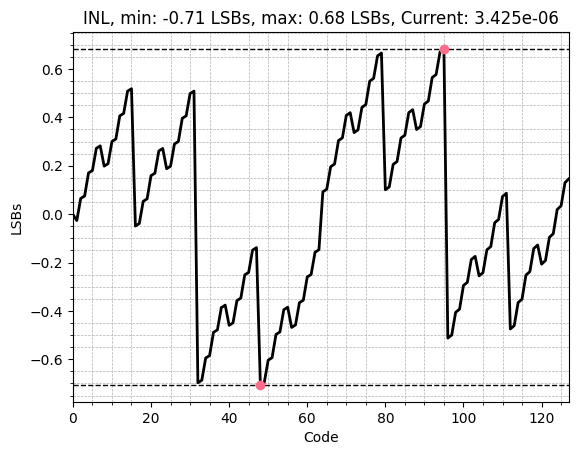

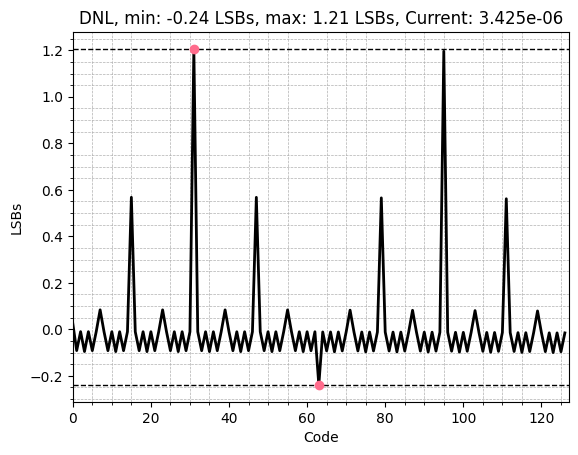

In [142]:
m2m_ladder_biased_mirrored_sim_directory = sim_directory.joinpath("m2m_ladder_biased_mirrored")

m2m_ladder_biased_mirrored_netlist = get_netlist(
    schematic=m2m_ladder_biased_mirrored_tb_schematic, output=m2m_ladder_biased_mirrored_sim_directory
)

m2m_ladder_biased_mirrored_data = run_simulation(
    netlist=m2m_ladder_biased_mirrored_netlist, output=m2m_ladder_biased_mirrored_sim_directory
)

calculate_inl(file=m2m_ladder_biased_mirrored_data, input_current=target_ladder_current)
calculate_dnl(file=m2m_ladder_biased_mirrored_data, input_current=target_ladder_current)


### Mismatch
With a complete DAC, I simulated mismatch with a series of simulations using the tt_mm mismatch model in the sky130 PDK.

(-0.20312656350364533, 0.9943569751824821)

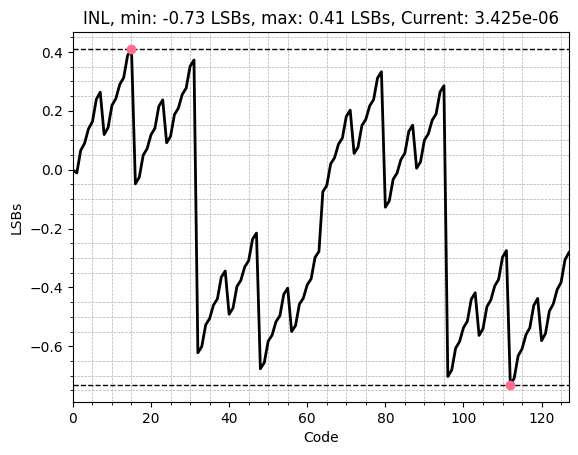

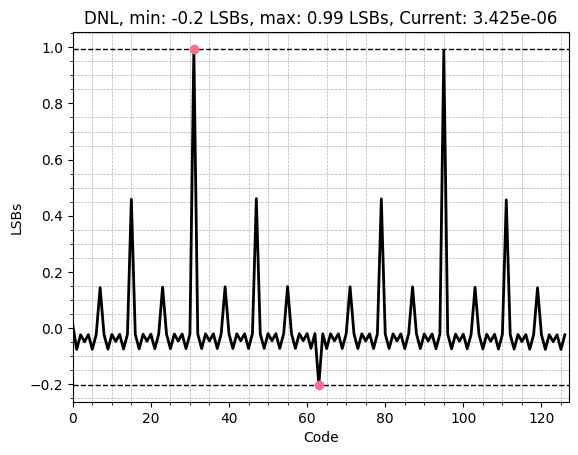

In [ ]:
delta_current_inls = []
delta_current_dnls = []

for _ in range(0,10):
  m2m_ladder_biased_mirrored_mm_tb_schematic = mp_root.joinpath("schematic/m2m_ladder_biased_mirrored_mm_tb.sch")
  m2m_ladder_biased_mirrored_mm_sim_directory = sim_directory.joinpath("m2m_ladder_biased_mirrored_mm")

  m2m_ladder_biased_mirrored_mm_netlist = get_netlist(
      schematic=m2m_ladder_biased_mirrored_mm_tb_schematic, output=m2m_ladder_biased_mirrored_mm_sim_directory
  )

  m2m_ladder_biased_mirrored_mm_data = run_simulation(
      netlist=m2m_ladder_biased_mirrored_mm_netlist, output=m2m_ladder_biased_mirrored_mm_sim_directory
  )

  _, _, _, _, delta_current_inl = calculate_inl(file= m2m_ladder_biased_mirrored_mm_data, input_current=target_ladder_current, suppress_plot=True)
  _, _, _, _, delta_current_dnl = calculate_dnl(file=m2m_ladder_biased_mirrored_mm_data, input_current=target_ladder_current)

  delta_current_inls.append(delta_current_inl)
  delta_current_dnls.append(delta_current_dnl)


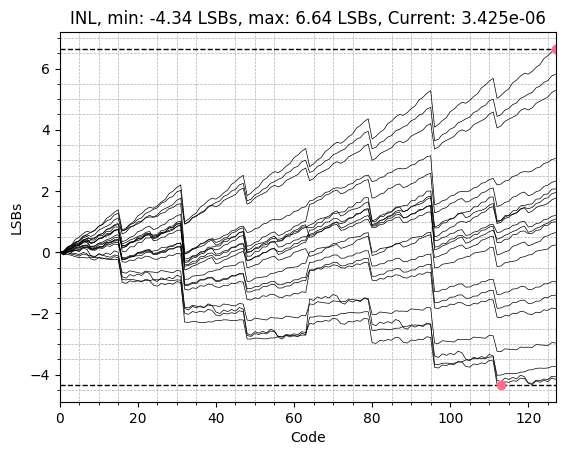

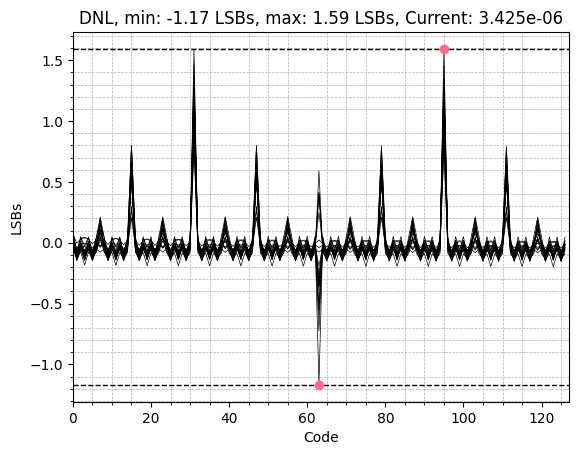

In [14]:
%autoreload 2
m2m_ladder_biased_mirrored_mm_tb_schematic = mp_root.joinpath("schematic/m2m_ladder_biased_mirrored_mm_tb.sch")
m2m_ladder_biased_mirrored_mm_sim_directory = sim_directory.joinpath("m2m_ladder_biased_mirrored_mm")

run_monte_carlo(file=m2m_ladder_biased_mirrored_mm_tb_schematic, build_directory=m2m_ladder_biased_mirrored_mm_sim_directory, input_current=target_ladder_current, runs=20)

### Output Current Over Output Voltage
The current mirror should ensure the output current remains constant with changes in the output voltage as shown in the simulation of the current mirror. Below are the testbench and results of sweeping the output voltage vs the output current.

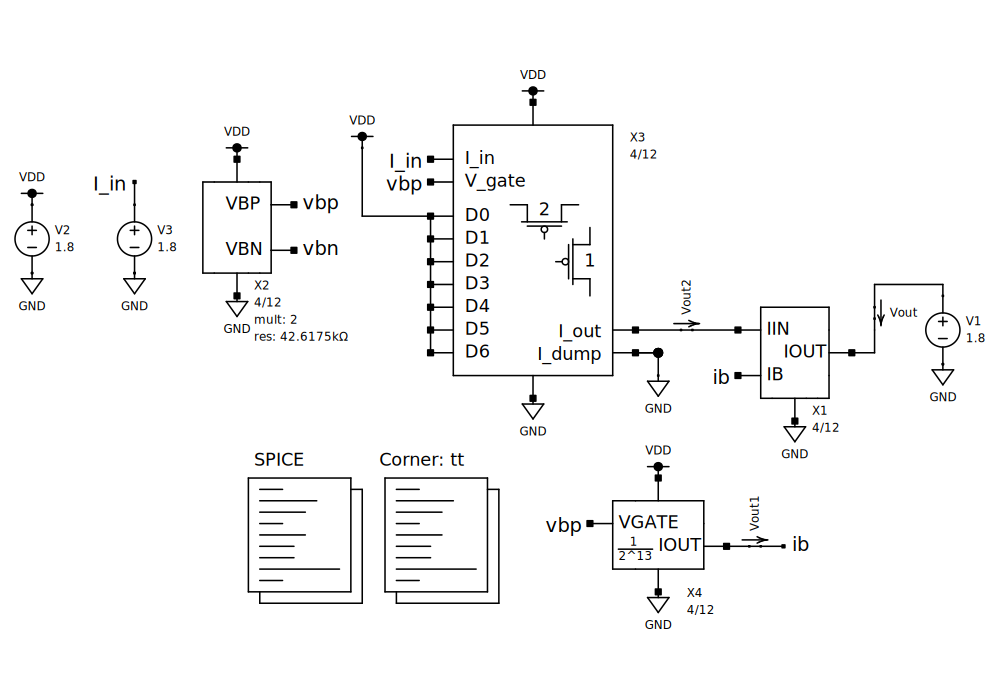

In [33]:
%autoreload 2
dac_output_voltage_tb_schematic = mp_root.joinpath("schematic/dac_output_voltage_tb.sch")
export_schematic(schematic=dac_output_voltage_tb_schematic, output=media_directory.joinpath("dac_output_voltage_tb.svg"))
display(SVG(media_directory.joinpath("dac_output_voltage_tb.svg")))

In [34]:
dac_output_voltage_sim_directory = sim_directory.joinpath("dac_output_voltage")

dac_output_voltage_netlist = get_netlist(
    schematic=dac_output_voltage_tb_schematic, output=dac_output_voltage_sim_directory
)

dac_output_voltage_data = run_simulation(
    netlist=dac_output_voltage_netlist, output=dac_output_voltage_sim_directory
)

1.4877826388888731e-08


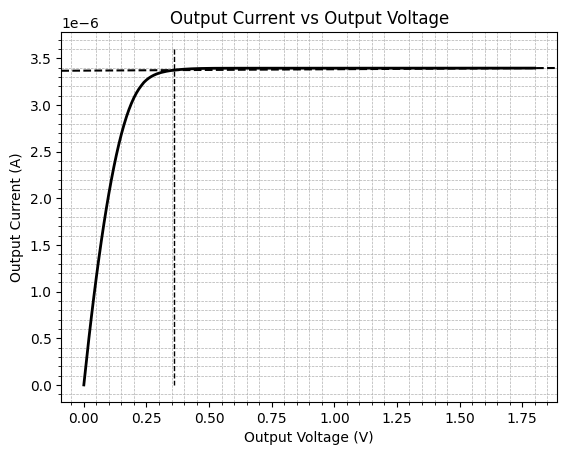

In [96]:
_dac_output_voltage_data, _ = parse_data(dac_output_voltage_data)

slope = (3.39433444e-06 - 3.37291037e-06 ) / (1.8 - 0.36)
print(slope)
intercept = (slope * 1.8) - 3.39433444e-06

plt.figure()
plt.title("Output Current vs Output Voltage")
plt.xlabel("Output Voltage (V)")
plt.ylabel("Output Current (A)")
plt.grid(which="minor", linestyle="--", linewidth=0.5)
plt.minorticks_on()
plt.plot(_dac_output_voltage_data["v-sweep"], _dac_output_voltage_data["i(Vout)"], color=black, linewidth=2)
plt.vlines(1.8 * 0.2, 3.6e-6, 0, linestyle="--", linewidth=1, color=black)
plt.axline((0,-intercept), slope = slope, linestyle="--", color=black)

Over 80% of the power supply voltage (0.36-1.8V), the output current stays between 3.37uA-3.39uA, with a slope of 14.8nA/V or 0.44%/V of the 3.425uA FSR.

### Output Current Over Power Supply Voltage


To test the output current over the power supply voltage, I tied all DAC inputs to Vdd and swept the power supply voltage.

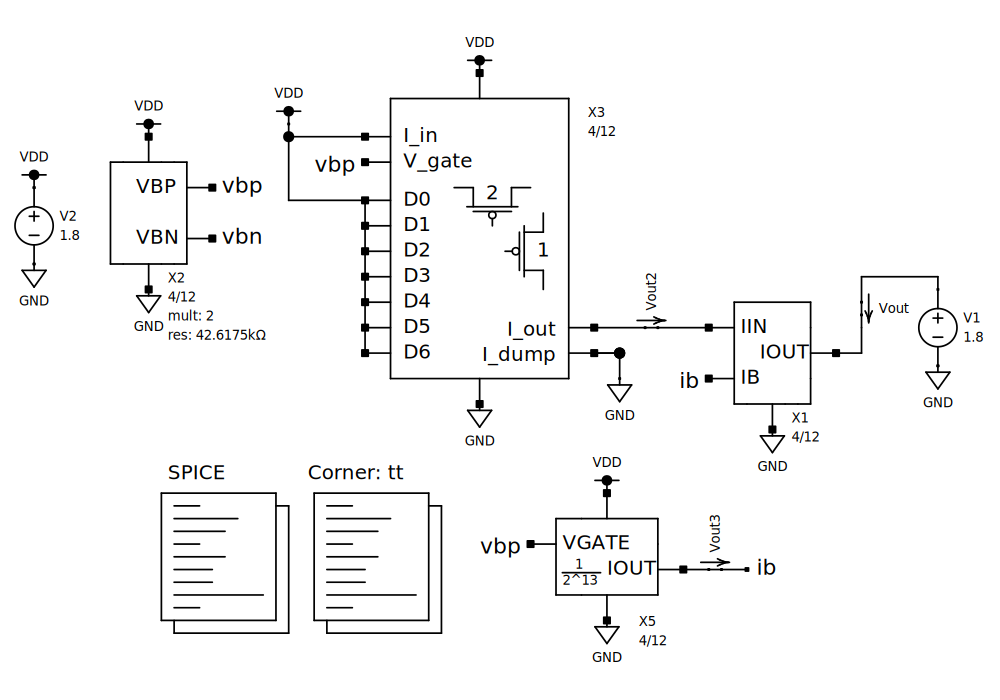

In [102]:
%autoreload 2
dac_supply_voltage_tb_schematic = mp_root.joinpath("schematic/dac_supply_voltage_tb.sch")
export_schematic(schematic=dac_supply_voltage_tb_schematic, output=media_directory.joinpath("dac_supply_voltage_tb.svg"))
display(SVG(media_directory.joinpath("dac_supply_voltage_tb.svg")))

In [103]:
dac_supply_voltage_sim_directory = sim_directory.joinpath("dac_supply_voltage")

dac_supply_voltage_netlist = get_netlist(
    schematic=dac_supply_voltage_tb_schematic, output=dac_supply_voltage_sim_directory
)

dac_supply_voltage_data = run_simulation(
    netlist=dac_supply_voltage_netlist, output=dac_supply_voltage_sim_directory
)

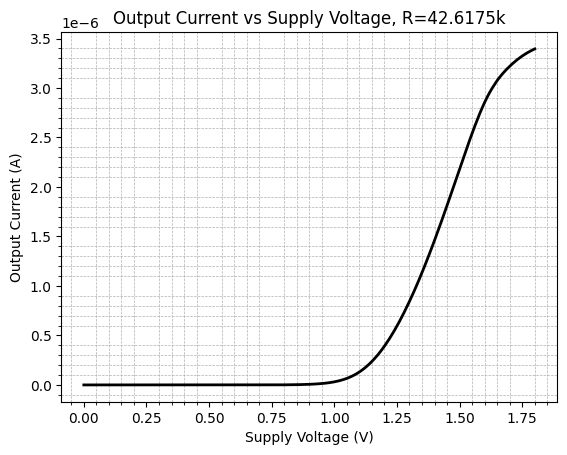

In [104]:
_dac_supply_voltage_data, _ = parse_data(dac_supply_voltage_data)

plt.figure()
plt.title("Output Current vs Supply Voltage, R=42.6175k")
plt.xlabel("Supply Voltage (V)")
plt.ylabel("Output Current (A)")
plt.grid(which="minor", linestyle="--", linewidth=0.5)
plt.minorticks_on()
plt.plot(_dac_supply_voltage_data["v-sweep"], _dac_supply_voltage_data["i(Vout)"], color=black, linewidth=2)

As can be seen from the output current as a function of the supply voltage, my DAC is not even remotely supply-independent. I had not realized and not tested the the supply-independence of the bias generator. 

I ran out of time to fully investigate, but increasing the bias generator degeneration resistor to 100k and moving the bias generator into weak inversion allows the bias generator to output a near constant current around the supply voltage. All of the above simulations could be rerun with a lower bias current to meet all DAC requirements.

In [107]:
dac_supply_voltage_sim_directory = sim_directory.joinpath("dac_supply_voltage")

dac_supply_voltage_netlist = get_netlist(
    schematic=dac_supply_voltage_tb_schematic, output=dac_supply_voltage_sim_directory
)

dac_supply_voltage_data = run_simulation(
    netlist=dac_supply_voltage_netlist, output=dac_supply_voltage_sim_directory
)

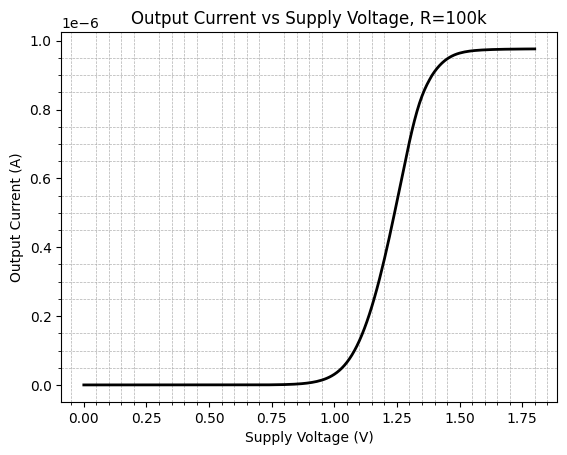

In [108]:
_dac_supply_voltage_data, _ = parse_data(dac_supply_voltage_data)

plt.figure()
plt.title("Output Current vs Supply Voltage, R=100k")
plt.xlabel("Supply Voltage (V)")
plt.ylabel("Output Current (A)")
plt.grid(which="minor", linestyle="--", linewidth=0.5)
plt.minorticks_on()
plt.plot(_dac_supply_voltage_data["v-sweep"], _dac_supply_voltage_data["i(Vout)"], color=black, linewidth=2)

## Layout

For each subcircuit, I made small adjustments for layout. Most changes were to the transistor widths such that they were not longer variables, but for the current divider I rearranged transistors and added dummy devices. Functionally, nothing was changed from the above simulations except for the removal of the capacitors in the bias generator and the current mirror. Each layout passes LVS and is free from DRC errors.

### Current Divider

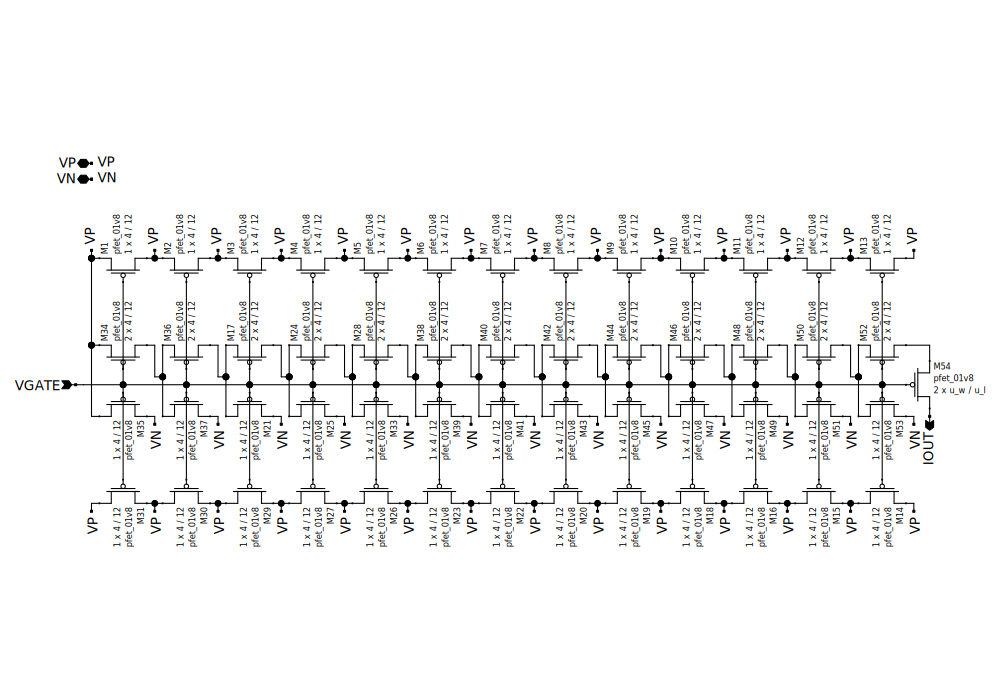

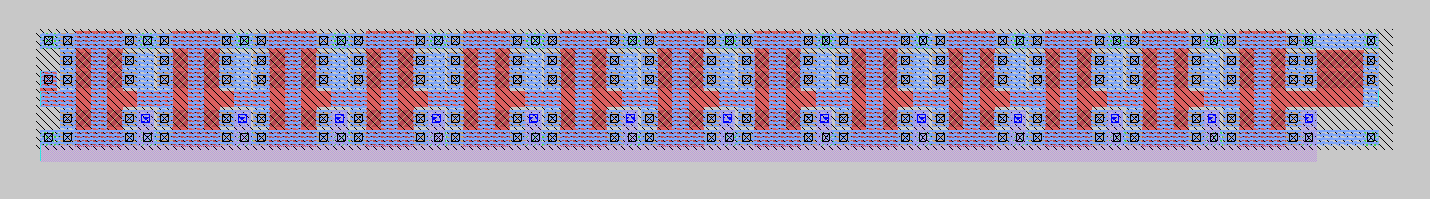

In [4]:
%autoreload 2
current_divider_layout_schematic = layout_directory.joinpath("current_divider/current_divider_layout.sch")
export_schematic(schematic=current_divider_layout_schematic, output=media_directory.joinpath("current_divider_layout_schematic.svg"))
display(SVG(media_directory.joinpath("current_divider_layout_schematic.svg")))
display(Image(media_directory.joinpath("current_divider_layout.png")))

Dummy devices were added on the outside of the current dividing transistors, though admittedly, they would be better placed on both sides the current dividing transistors, as the expense of more area. I do not believe there is much merit to these dummy devices.

In [9]:
with open(layout_directory.joinpath("current_divider/lvs/current_divider.out")) as current_divider_lvs:
    contents = current_divider_lvs.read()
    display(Markdown(f"```text\n{contents}\n```"))

```text

Circuit 1 cell sky130_fd_pr__pfet_01v8 and Circuit 2 cell sky130_fd_pr__pfet_01v8 are black boxes.
Equate elements:  no current cell.
Device classes sky130_fd_pr__pfet_01v8 and sky130_fd_pr__pfet_01v8 are equivalent.

Class current_divider_schematic.spice (0):  Merged 25 parallel devices.
Class current_divider_layout.spice (1):  Merged 39 parallel devices.
Subcircuit summary:
Circuit 1: current_divider_schematic.spice |Circuit 2: current_divider_layout.spice    
-------------------------------------------|-------------------------------------------
sky130_fd_pr__pfet_01v8 (67->28)           |sky130_fd_pr__pfet_01v8 (67->28)           
Number of devices: 28                      |Number of devices: 28                      
Number of nets: 17                         |Number of nets: 17                         
---------------------------------------------------------------------------------------
Netlists match uniquely with property errors.
sky130_fd_pr__pfet_01v8:M54 vs. sky130_fd_pr__pfet_01v8:1:
 W circuit1: "u_w"   circuit2: "4"   (exact match req'd)
 L circuit1: "u_l"   circuit2: "12"   (exact match req'd)
Cells have no pins;  pin matching not needed.
Device classes current_divider_schematic.spice and current_divider_layout.spice are equivalent.

Final result: Circuits match uniquely.
Property errors were found.

The following cells had property errors:
 current_divider_schematic.spice

```

### M-2M Ladder

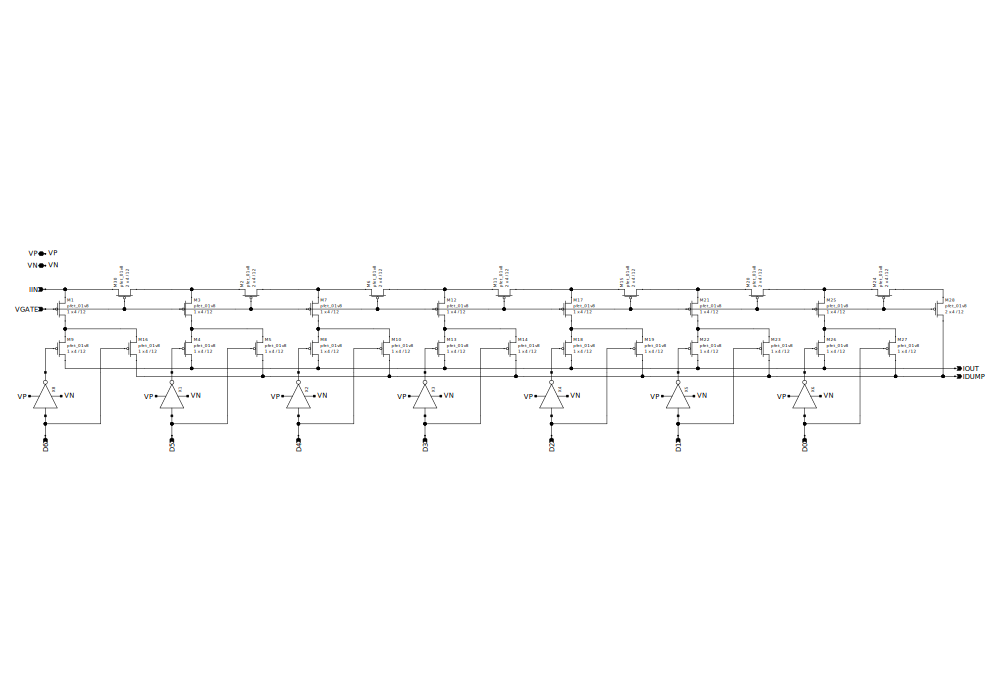

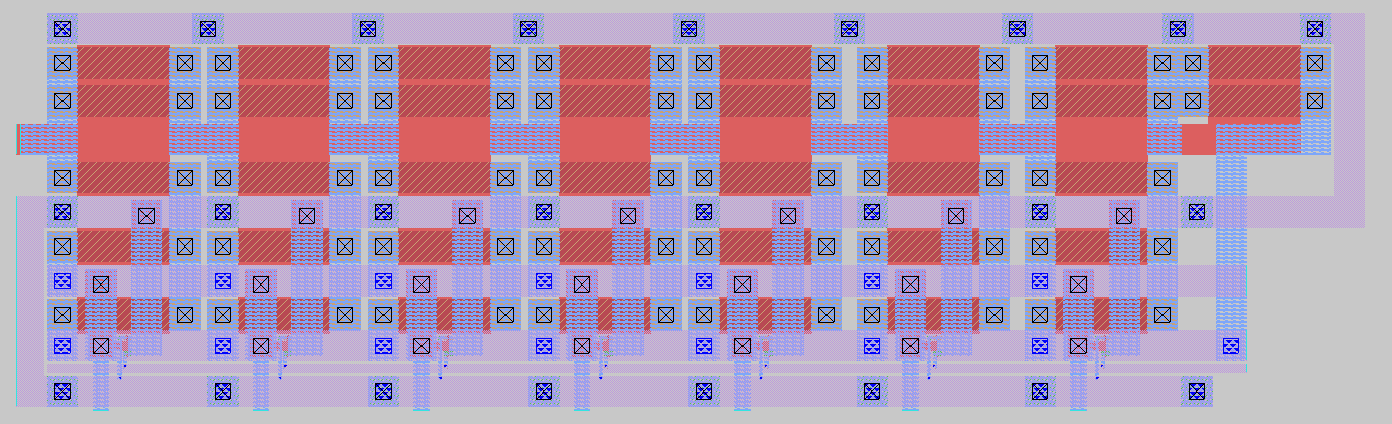

In [5]:
%autoreload 2
m2m_ladder_layout_schematic = layout_directory.joinpath("m2m_ladder/m2m_ladder_layout.sch")
export_schematic(schematic=m2m_ladder_layout_schematic, output=media_directory.joinpath("m2m_ladder_layout_schematic.svg"))
display(SVG(media_directory.joinpath("m2m_ladder_layout_schematic.svg")))
display(Image(media_directory.joinpath("m2m_ladder_layout.png")))

In [3]:
with open(layout_directory.joinpath("m2m_ladder/lvs/m2m_ladder.out")) as m2m_ladder_lvs:
    contents = m2m_ladder_lvs.read()
    display(Markdown(f"```text\n{contents}\n```"))

```text

Circuit 1 cell sky130_fd_pr__nfet_01v8 and Circuit 2 cell sky130_fd_pr__nfet_01v8 are black boxes.
Equate elements:  no current cell.
Device classes sky130_fd_pr__nfet_01v8 and sky130_fd_pr__nfet_01v8 are equivalent.

Circuit 1 cell sky130_fd_pr__pfet_01v8 and Circuit 2 cell sky130_fd_pr__pfet_01v8 are black boxes.
Equate elements:  no current cell.
Device classes sky130_fd_pr__pfet_01v8 and sky130_fd_pr__pfet_01v8 are equivalent.
Flattening unmatched subcell inverter in circuit m2m_ladder_schematic.spice (1)(7 instances)

Class m2m_ladder_layout.spice (0):  Merged 8 parallel devices.
Subcircuit summary:
Circuit 1: m2m_ladder_layout.spice         |Circuit 2: m2m_ladder_schematic.spice      
-------------------------------------------|-------------------------------------------
sky130_fd_pr__pfet_01v8 (44->36)           |sky130_fd_pr__pfet_01v8 (44->36)           
sky130_fd_pr__nfet_01v8 (7)                |sky130_fd_pr__nfet_01v8 (7)                
Number of devices: 43                      |Number of devices: 43                      
Number of nets: 34                         |Number of nets: 34                         
---------------------------------------------------------------------------------------
Netlists match uniquely.
Cells have no pins;  pin matching not needed.
Device classes m2m_ladder_layout.spice and m2m_ladder_schematic.spice are equivalent.

Final result: Circuits match uniquely.
.

```

### Bias Generator

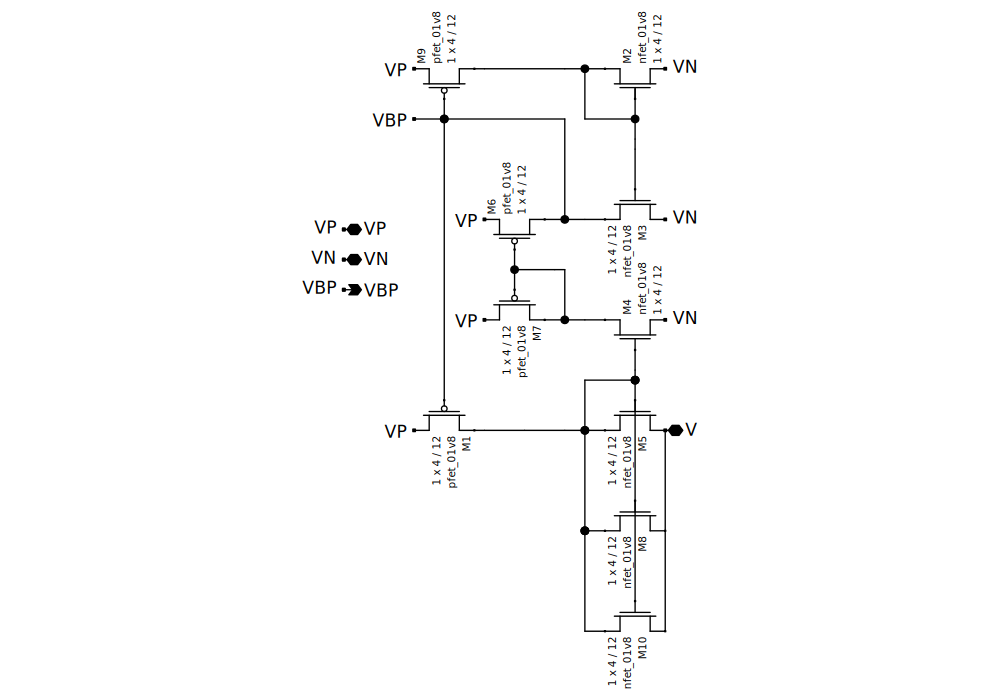

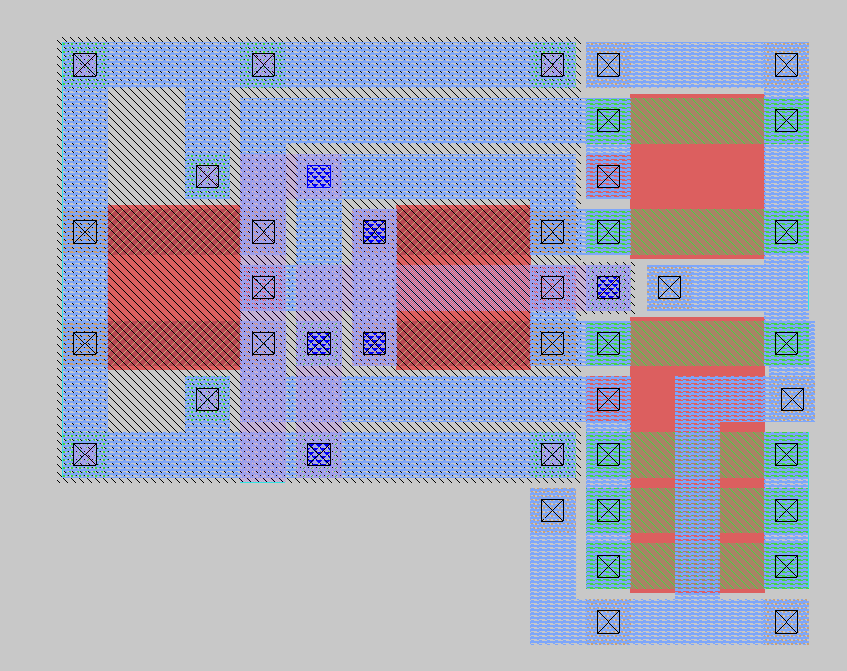

In [11]:
%autoreload 2
bias_gen_layout_schematic = layout_directory.joinpath("bias_gen/bias_gen_layout.sch")
export_schematic(schematic=bias_gen_layout_schematic, output=media_directory.joinpath("bias_gen_layout_schematic.svg"))
display(SVG(media_directory.joinpath("bias_gen_layout_schematic.svg")))
display(Image(media_directory.joinpath("bias_gen_layout.png")))

In [12]:
with open(layout_directory.joinpath("bias_gen/lvs/bias_gen.out")) as bias_gen_lvs:
    contents = bias_gen_lvs.read()
    display(Markdown(f"```text\n{contents}\n```"))

```text

Circuit 1 cell sky130_fd_pr__pfet_01v8 and Circuit 2 cell sky130_fd_pr__pfet_01v8 are black boxes.
Equate elements:  no current cell.
Device classes sky130_fd_pr__pfet_01v8 and sky130_fd_pr__pfet_01v8 are equivalent.

Circuit 1 cell sky130_fd_pr__nfet_01v8 and Circuit 2 cell sky130_fd_pr__nfet_01v8 are black boxes.
Equate elements:  no current cell.
Device classes sky130_fd_pr__nfet_01v8 and sky130_fd_pr__nfet_01v8 are equivalent.

Class bias_gen_layout.spice (0):  Merged 2 parallel devices.
Class bias_gen_schematic.spice (1):  Merged 2 parallel devices.
Subcircuit summary:
Circuit 1: bias_gen_layout.spice           |Circuit 2: bias_gen_schematic.spice        
-------------------------------------------|-------------------------------------------
sky130_fd_pr__pfet_01v8 (4)                |sky130_fd_pr__pfet_01v8 (4)                
sky130_fd_pr__nfet_01v8 (6->4)             |sky130_fd_pr__nfet_01v8 (6->4)             
Number of devices: 8                       |Number of devices: 8                       
Number of nets: 7                          |Number of nets: 7                          
---------------------------------------------------------------------------------------
Netlists match uniquely.
Cells have no pins;  pin matching not needed.
Device classes bias_gen_layout.spice and bias_gen_schematic.spice are equivalent.

Final result: Circuits match uniquely.
.

```

### Current Mirror

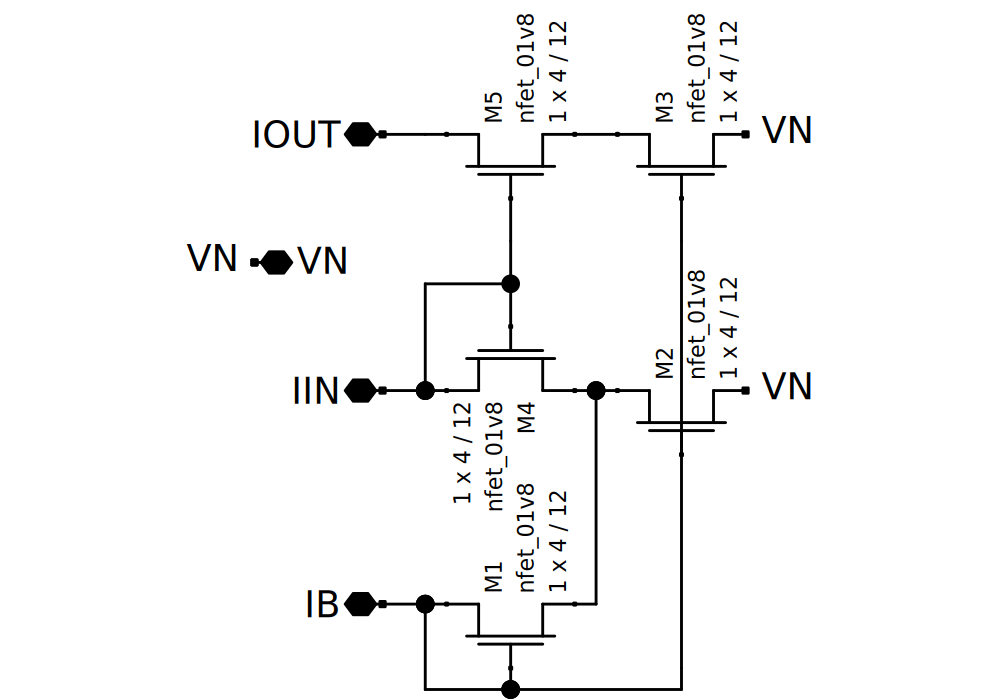

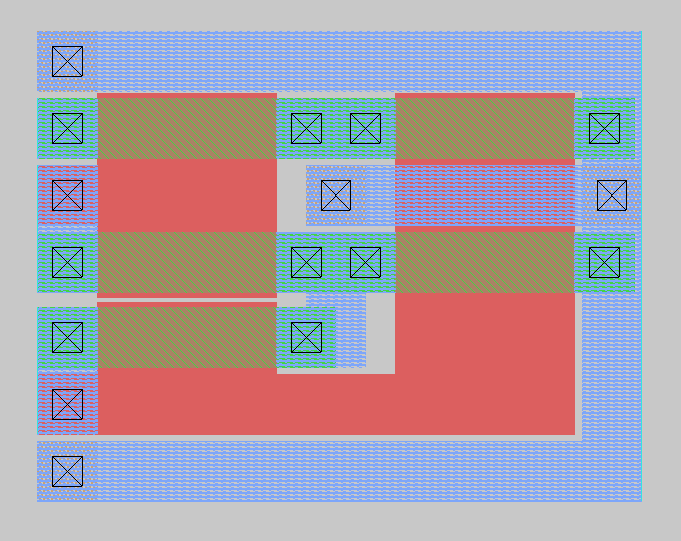

In [15]:
%autoreload 2
current_mirror_layout_schematic = layout_directory.joinpath("current_mirror/lvs_mirror_layout.sch")
export_schematic(schematic=current_mirror_layout_schematic, output=media_directory.joinpath("current_mirror_layout_schematic.svg"))
display(SVG(media_directory.joinpath("current_mirror_layout_schematic.svg")))
display(Image(media_directory.joinpath("current_mirror_layout.png")))

In [6]:
with open(layout_directory.joinpath("current_mirror/lvs/current_mirror.out")) as current_mirror_lvs:
    contents = current_mirror_lvs.read()
    display(Markdown(f"```text\n{contents}\n```"))

```text

Circuit 1 cell sky130_fd_pr__nfet_01v8 and Circuit 2 cell sky130_fd_pr__nfet_01v8 are black boxes.
Equate elements:  no current cell.
Device classes sky130_fd_pr__nfet_01v8 and sky130_fd_pr__nfet_01v8 are equivalent.

Subcircuit summary:
Circuit 1: current_mirror_layout.spice     |Circuit 2: current_mirror_schematic.spice  
-------------------------------------------|-------------------------------------------
sky130_fd_pr__nfet_01v8 (5)                |sky130_fd_pr__nfet_01v8 (5)                
Number of devices: 5                       |Number of devices: 5                       
Number of nets: 6                          |Number of nets: 6                          
---------------------------------------------------------------------------------------
Netlists match uniquely.
Cells have no pins;  pin matching not needed.
Device classes current_mirror_layout.spice and current_mirror_schematic.spice are equivalent.

Final result: Circuits match uniquely.
.

```

### Complete DAC



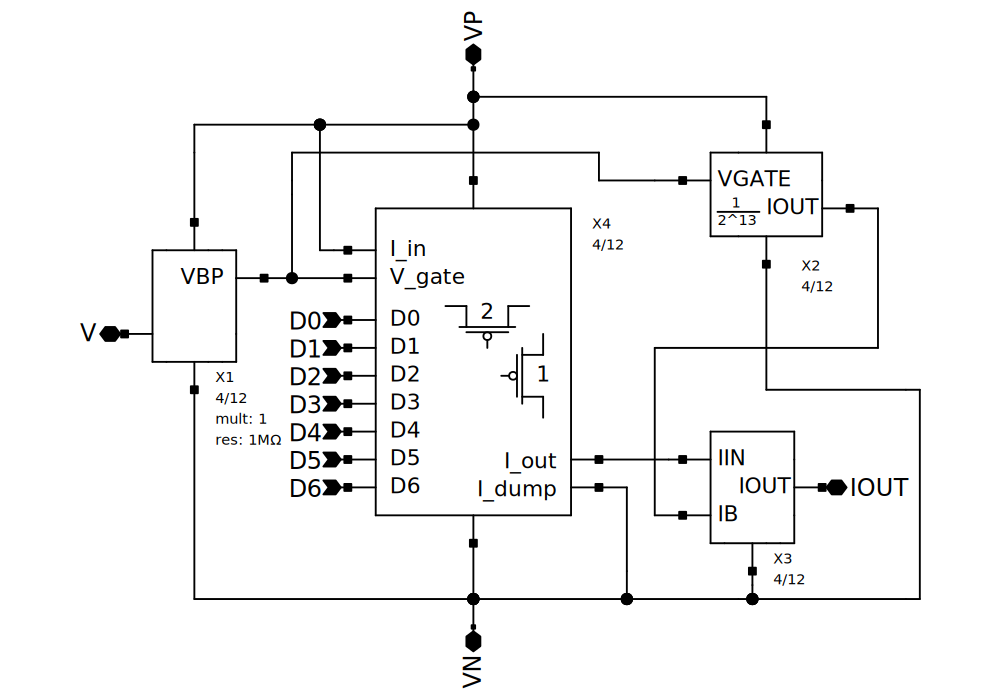

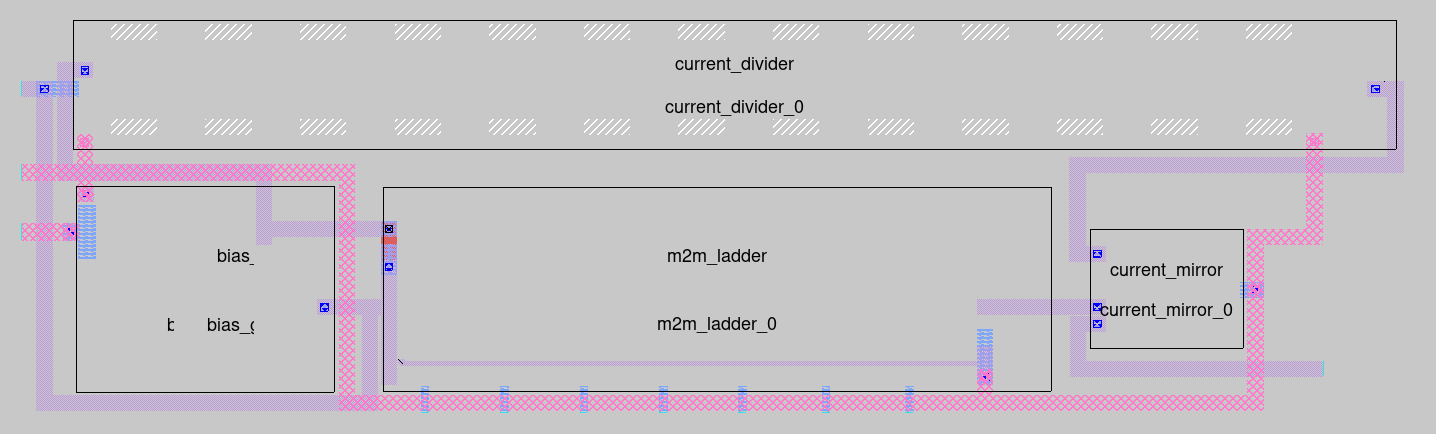

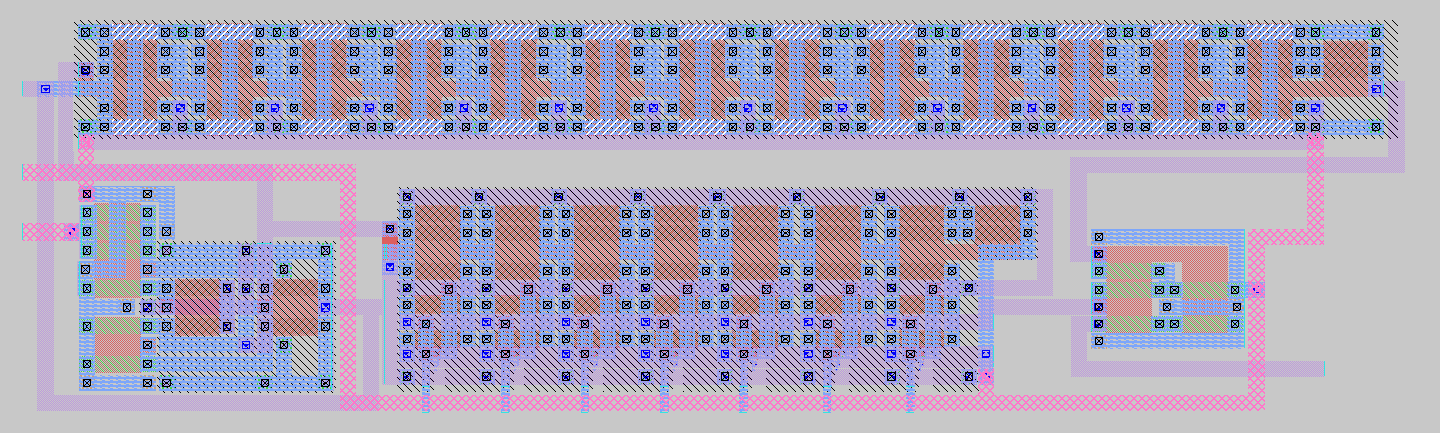

In [7]:
%autoreload 2
dac_layout_schematic = layout_directory.joinpath("dac_layout.sch")
export_schematic(schematic=dac_layout_schematic, output=media_directory.joinpath("dac_layout_schematic.svg"))
display(SVG(media_directory.joinpath("dac_layout_schematic.svg")))
display(Image(media_directory.joinpath("dac_unexpanded.png")))
display(Image(media_directory.joinpath("dac.png")))

### Appendix: Source Files

All source files can be found at [https://github.com/drewnotdrew/madvlsi](https://github.com/drewnotdrew/madvlsi).